In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from huber_regressor import RobustOnlineHuberRegressor, preprocess_data
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 資料整理

In [2]:
df=pd.read_csv("dataset/house-prices-advanced-regression-techniques/train.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

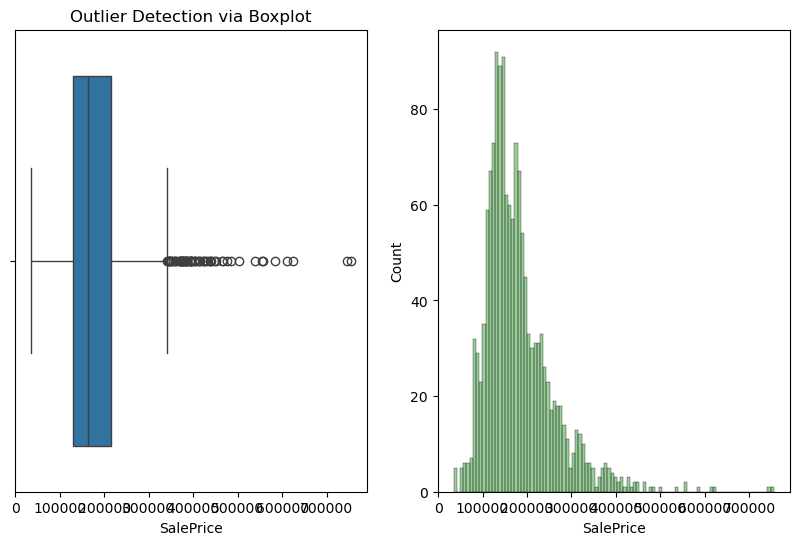

In [3]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.boxplot(x=df["SalePrice"])
plt.title("Outlier Detection via Boxplot")
plt.subplot(1,2,2)
sns.histplot(df['SalePrice'], color='g', bins=100, alpha=0.4)
plt.show()

In [4]:
categories = [
        'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
        'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
        'SaleCondition'
    ]
df=preprocess_data(df,categories)

In [5]:
df = df.drop(df[df["SalePrice"]>350000].index, axis=0)
df = df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'MiscVal'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df.isnull().sum())
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())

# 訓練

In [6]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

訓練完成統計：
計算時間: 0.99秒
MAE: 15076.02
RMSE:21379.472806010825


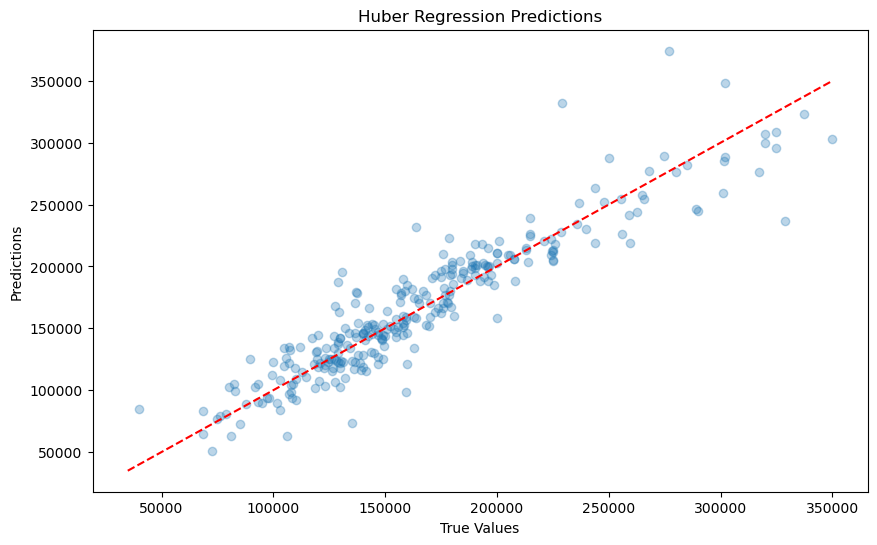

count       282.000000
mean     166077.322695
std       56356.873172
min       40000.000000
25%      129000.000000
50%      156716.000000
75%      193250.000000
max      350000.000000
Name: SalePrice, dtype: float64


In [8]:
# 分割訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 安全標準化（添加缺失值檢查）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 確保無NaN/inf
assert not np.any(np.isnan(X_train_scaled)), "訓練集仍含NaN"
assert not np.any(np.isinf(X_train_scaled)), "訓練集含Inf"

# 初始化魯棒回歸器
huber_model = RobustOnlineHuberRegressor(
    k=1.345,          # Huber損失閾值
    fit_intercept=True, 
    reg_param=1e-4     # 正則化強度
)

start_time = time.time()

# 分批訓練
batch_size = 10000
compute_time = 0
for i in range(0, len(X_train_scaled), batch_size):
    X_batch = X_train_scaled[i:i+batch_size]
    y_batch = y_train.iloc[i:i+batch_size].values  # 轉為numpy array
    
    compute_start = time.time()    
    huber_model.fit_batch(X_batch, y_batch)
    compute_time += time.time() - compute_start

# 計算最終係數
huber_model.finalize()

print(f"訓練完成統計：")
print(f"計算時間: {compute_time:.2f}秒")

from sklearn.metrics import mean_absolute_error, mean_squared_error

# 驗證集預測
y_val_pred = huber_model.predict(X_val_scaled)

# 計算指標
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print("RMSE:" + str(mean_squared_error(y_val, y_val_pred)**0.5))

# 可視化預測 vs 真實值
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Huber Regression Predictions")
plt.show()
print(y_val.describe())